train 500000
validation 100000
test 1000
0:	learn: 0.8322783	test: 0.8330736	best: 0.8330736 (0)	total: 144ms	remaining: 2m 23s
100:	learn: 0.9032451	test: 0.9031856	best: 0.9031856 (100)	total: 7.5s	remaining: 1m 6s
200:	learn: 0.9132692	test: 0.9130450	best: 0.9130450 (200)	total: 14.7s	remaining: 58.4s
300:	learn: 0.9188784	test: 0.9185257	best: 0.9185257 (300)	total: 22s	remaining: 51.1s
400:	learn: 0.9220972	test: 0.9217271	best: 0.9217518 (399)	total: 29.2s	remaining: 43.7s
500:	learn: 0.9245722	test: 0.9243603	best: 0.9243736 (498)	total: 36.4s	remaining: 36.2s
600:	learn: 0.9264991	test: 0.9261555	best: 0.9262051 (596)	total: 43.5s	remaining: 28.9s
700:	learn: 0.9280979	test: 0.9279370	best: 0.9279370 (700)	total: 50.8s	remaining: 21.7s
800:	learn: 0.9293965	test: 0.9293714	best: 0.9293714 (800)	total: 58s	remaining: 14.4s
900:	learn: 0.9305190	test: 0.9305532	best: 0.9305924 (897)	total: 1m 5s	remaining: 7.16s
999:	learn: 0.9316023	test: 0.9315834	best: 0.9316207 (986)	total: 

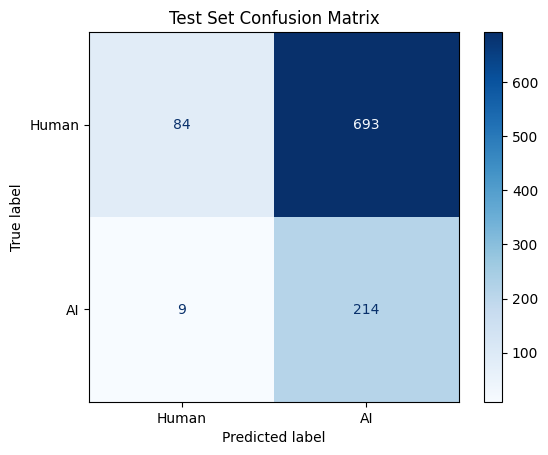

In [2]:
# -*- coding: utf-8 -*-
"""CatBoost SemEval Task 13 Pipeline with Seen/Unseen Language Metrics"""

# --- Imports ---
import re
import pandas as pd
from datasets import load_dataset
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# --- Load Dataset ---
ds = load_dataset("DaniilOr/SemEval-2026-Task13", 'A')

for split in ds:
    print(split, len(ds[split]))

import re

def extract_code_features(code: str, language: str = None):
    """
    Extract rich features from a code snippet for human vs AI classification.
    Supports language-specific patterns if language is provided.
    """
    # --- Basic line metrics ---
    lines = code.split("\n")
    num_lines = len(lines)
    avg_line_len = sum(len(l) for l in lines) / num_lines if num_lines > 0 else 0
    num_blank_lines = sum(1 for l in lines if not l.strip())
    
    # --- Comments ---
    num_comments = len(re.findall(r"(#|//|/\*.*?\*/)", code, re.DOTALL))
    comment_ratio = num_comments / num_lines if num_lines > 0 else 0
    
    # --- Loops and conditionals ---
    num_for = len(re.findall(r"\bfor\b", code))
    num_while = len(re.findall(r"\bwhile\b", code))
    num_if = len(re.findall(r"\bif\b", code))
    num_else = len(re.findall(r"\belse\b", code))
    
    # --- Functions & classes ---
    num_functions = len(re.findall(r"\bdef\b|\bfunction\b|\b[A-Za-z_]+\s*\(", code))
    num_classes = len(re.findall(r"\bclass\b", code))
    
    # --- Operators & special symbols ---
    num_operators = len(re.findall(r"[+\-*/=<>!%&|^]", code))
    num_braces = code.count("{") + code.count("}")
    num_parentheses = code.count("(") + code.count(")")
    num_semicolons = code.count(";")
    
    # --- Tokens statistics ---
    tokens = re.findall(r"[A-Za-z_][A-Za-z0-9_]*", code)
    avg_token_len = sum(len(t) for t in tokens) / len(tokens) if tokens else 0
    num_keywords = 0
    if language:
        # Some common keywords per language
        lang_keywords = {
            "Python": ["def", "class", "if", "elif", "else", "for", "while", "import", "from", "return", "try", "except"],
            "Java": ["class", "public", "private", "protected", "if", "else", "for", "while", "import", "return", "try", "catch"],
            "C++": ["class", "public", "private", "protected", "if", "else", "for", "while", "return", "try", "catch", "include"],
            "C": ["if", "else", "for", "while", "return", "include"],
            "Go": ["func", "if", "else", "for", "package", "return", "import"],
            "PHP": ["function", "if", "else", "for", "while", "return"],
            "C#": ["class", "public", "private", "if", "else", "for", "while", "return", "try", "catch"],
            "JS": ["function", "if", "else", "for", "while", "return", "const", "let", "var", "try", "catch"]
        }
        keywords = lang_keywords.get(language, [])
        num_keywords = sum(code.count(kw) for kw in keywords)
    
    # --- Ratio features ---
    lines_per_function = num_lines / num_functions if num_functions else num_lines
    operators_per_line = num_operators / num_lines if num_lines else 0
    braces_per_line = num_braces / num_lines if num_lines else 0
    parentheses_per_line = num_parentheses / num_lines if num_lines else 0
    
    # --- Return as dict ---
    return {
        "num_lines": num_lines,
        "avg_line_len": avg_line_len,
        "num_blank_lines": num_blank_lines,
        "num_comments": num_comments,
        "comment_ratio": comment_ratio,
        "num_for": num_for,
        "num_while": num_while,
        "num_if": num_if,
        "num_else": num_else,
        "num_functions": num_functions,
        "num_classes": num_classes,
        "num_operators": num_operators,
        "num_braces": num_braces,
        "num_parentheses": num_parentheses,
        "num_semicolons": num_semicolons,
        "avg_token_len": avg_token_len,
        "num_keywords": num_keywords,
        "lines_per_function": lines_per_function,
        "operators_per_line": operators_per_line,
        "braces_per_line": braces_per_line,
        "parentheses_per_line": parentheses_per_line,
    }


# --- Build Feature DataFrames ---
def build_feature_dataframe(split_name, num_samples=None):
    data_list = []
    labels = []
    languages = []
    for i, example in enumerate(ds[split_name]):
        if num_samples and i >= num_samples:
            break
        code = example['code']
        label = example['label']
        language = example['language']
        features = extract_code_features(code)
        data_list.append(features)
        labels.append(label)
        languages.append(language)
    X = pd.DataFrame(data_list)
    y = pd.Series(labels)
    langs = pd.Series(languages)
    return X, y, langs

# --- Exact splits ---
X_train, y_train, _ = build_feature_dataframe('train', num_samples=500_000)
X_val, y_val, _ = build_feature_dataframe('train', num_samples=100_000)  # next 100k for validation
X_test, y_test, test_languages = build_feature_dataframe('test', num_samples=1_000)

# --- Train CatBoost ---
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    verbose=100,
    class_weights=[y_train.value_counts()[1]/y_train.value_counts()[0], 1]
)

model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# --- Evaluation Function ---
def evaluate_and_plot(X, y, dataset_name="Dataset"):
    y_pred = model.predict(X)
    acc = (y_pred == y).mean()
    print(f"\n{dataset_name} Accuracy: {acc:.4f}")
    print(classification_report(y, y_pred, digits=4))
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "AI"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()
    return y_pred

# --- Evaluate Train, Validation, Test ---
# y_train_pred = evaluate_and_plot(X_train, y_train, "Training Set")
# y_val_pred = evaluate_and_plot(X_val, y_val, "Validation Set")
y_test_pred = evaluate_and_plot(X_test, y_test, "Test Set")

In [5]:
# --- After training CatBoost and predicting on test set ---
# Assuming:
# X_test: features of your test set
# y_test: true labels
# y_test_pred: predicted labels from model
# test_languages: list/Series of languages for test samples

import pandas as pd

# Create test_df
test_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_test_pred,
    "language": test_languages
})

# --- Define Seen and Unseen languages ---
seen_languages = ["C++", "Python", "Java"]
unseen_languages = ["Go", "PHP", "C#", "C", "JS"]

# Add category column
test_df["category"] = test_df["language"].apply(
    lambda x: "Seen" if x in seen_languages else "Unseen"
)

# --- Evaluation function ---
from sklearn.metrics import f1_score, classification_report

def evaluate_category(df, category_name, language_list):
    """Compute accuracy, macro F1, and classification report for a category"""
    category_df = df[df["category"] == category_name]
    n_samples = len(category_df)
    if n_samples == 0:
        print(f"\n--- {category_name} Languages Metrics ---")
        print(f"No samples for {category_name}.")
        return
    y_true = category_df["y_true"]
    y_pred = category_df["y_pred"]
    accuracy = (y_true == y_pred).mean()
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    
    print(f"\n--- {category_name} Languages Metrics ---")
    print(f"Languages: {', '.join(language_list)}")
    print(f"Samples: {n_samples}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(classification_report(y_true, y_pred, digits=4))

# --- Evaluate Seen ---
evaluate_category(test_df, "Seen", seen_languages)

# --- Evaluate Unseen ---
evaluate_category(test_df, "Unseen", unseen_languages)



--- Seen Languages Metrics ---
Languages: C++, Python, Java
Samples: 634
Accuracy: 0.3186
Macro F1: 0.3140
              precision    recall  f1-score   support

           0     0.9146    0.1500    0.2577       500
           1     0.2301    0.9478    0.3703       134

    accuracy                         0.3186       634
   macro avg     0.5724    0.5489    0.3140       634
weighted avg     0.7699    0.3186    0.2815       634


--- Unseen Languages Metrics ---
Languages: Go, PHP, C#, C, JS
Samples: 366
Accuracy: 0.2623
Macro F1: 0.2272
              precision    recall  f1-score   support

           0     0.8182    0.0325    0.0625       277
           1     0.2451    0.9775    0.3919        89

    accuracy                         0.2623       366
   macro avg     0.5316    0.5050    0.2272       366
weighted avg     0.6788    0.2623    0.1426       366



In [10]:
import pandas as pd
from sklearn.metrics import f1_score, classification_report

# Assuming test_df has columns: 'y_true', 'y_pred', 'language'

# Group by language
language_stats = []

for lang, group in test_df.groupby("language"):
    n_samples = len(group)
    n_correct = (group["y_true"] == group["y_pred"]).sum()
    accuracy = n_correct / n_samples if n_samples > 0 else 0
    macro_f1 = f1_score(group["y_true"], group["y_pred"], average="macro") if n_samples > 0 else 0
    language_stats.append({
        "Language": lang,
        "Samples": n_samples,
        "Correct": n_correct,
        "Accuracy": round(accuracy, 4),
        "Macro F1": round(macro_f1, 4)
    })

# Convert to DataFrame for pretty display
language_metrics_df = pd.DataFrame(language_stats).sort_values("Language")
print(language_metrics_df.to_string(index=False))


  Language  Samples  Correct  Accuracy  Macro F1
         C       51       10    0.1961    0.1758
        C#      122       29    0.2377    0.2043
       C++       75       21    0.2800    0.2788
        Go       60       16    0.2667    0.2105
      Java      256       50    0.1953    0.1841
JavaScript       85       33    0.3882    0.2944
       PHP       48        8    0.1667    0.1652
    Python      303      131    0.4323    0.4301
